# Νευρωνικά Δίκτυα

Παρακάτω θα παρουσιάσουμε μερικές αρχιτεκτονικές νευρωνικών δικτύων.

***

## Συναρτήσεις 

Οι παρακάτω βοηθητικές συναρτήσεις θα χρησιμοποιηθούν για να κάνουμε train και test το μοντέλο.

Αρχικά κάνουμε τα απαραίτητα imports και ορίζουμε την συσκευή που θα χρησιμοποιήσουμε (cpu/gpu).

In [1]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from torch import nn
import pandas as pd
import os
from torch.optim import lr_scheduler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from pathlib import Path

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device, imports complete!'.format(device))

Using cuda device, imports complete!


Στην συνέχεια ορίζουμε την πρώτη συνάρτηση η οποία δέχεται ένα μοντέλο, το training dataset, την συνάρτηση λάθους, τον optimizer, και την συσκευή που χρησιμοποιούμε. Προχωράει το training κατά ένα βήμα και επιστρέφει την απώλεια.

In [2]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device = 'cpu'):
    model.to(device)
    model.train()

    train_loss = 0
    for X_batch, y_batch in data_loader:
        # Send data to GPU
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        y_pred = model(X_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)

        # Zero gradients
        optimizer.zero_grad()

        # Backward pass
        loss.backward()

        # Update the weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping to prevent gradients exploding
        optimizer.step()

        train_loss += loss.item()
    
    return train_loss


Ομοίως η παρακάτω συνάρτηση κάνει test το μοντέλο σε κάθε εποχή, και επιστρέφει την απώλεια.

In [3]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device = 'cpu'):
    model.to(device)
    model.eval()

    test_loss = 0
    with torch.inference_mode():
        for X_batch, y_batch in data_loader:
            # Send data to GPU
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_test_pred = model(X_batch)
            test_loss += loss_fn(y_test_pred, y_batch).item()
    
    return test_loss

Ορίζουμε μία κλάση έτσι ώστε το μοντέλο μας να σταματάει νωρίς όταν παρατηρεί ότι το test loss αυξάνεται η μέθοδος αυτή είναι γνωστή και ως early stopping.

In [45]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0, verbose=False, path='best_model.pth'):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.path = path

        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            torch.save(model.state_dict(), self.path)
            if self.verbose:
                print(f"Validation loss decreased to {val_loss:.6f}. Saving model...")
        else:
            self.counter += 1
            if self.verbose:
                print(f"No improvement. Counter: {self.counter}/{self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True

Η βασική συνάρτηση, επαναληπτικά για όσες εποχές έχουμε διαλέξει κάνει train και test το μοντέλο, και ανά 10 εποχές εκτυπώνει τα αποτελέσματα. Επιστρέφει 2 πίνακες με τις συνολικές απώλειες σε κάθε επανάληψη.

In [73]:
def train_test_model(epoch: int, 
                     model: torch.nn.Module,
                     train_loader: torch.utils.data.DataLoader,
                     test_loader: torch.utils.data.DataLoader,
                     loss_fn: torch.nn.Module,
                     optimizer: torch.optim.Optimizer,
                     scheduler,
                     early_stopper = None,
                     device: torch.device = 'cpu'):

    torch.manual_seed(42)
    train_loss_arr = []
    test_loss_arr = []

    for epochs in range(epoch):
        # Train for one epoch
        epoch_loss = train_step(model, train_loader, loss_fn, optimizer, device)
        train_loss_arr.append(epoch_loss / len(train_loader))

        # Scheduler update
        scheduler.step(epoch_loss)
        after_lr = optimizer.param_groups[0]['lr']

        # Evaluate on test set
        test_loss = test_step(model, test_loader, loss_fn, device)
        test_loss_arr.append(test_loss / len(test_loader))

        # Print progress
        if (epochs % 10 == 0) or (epochs == 0):
            print(f'Epoch {epochs} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')
        elif epochs + 1 == epoch:
            print(f'Epoch {epoch} | Loss train: {train_loss_arr[-1]:.6f} | Loss test: {test_loss_arr[-1]:.6f} | lr = {after_lr}')

        # Early stopping check
        early_stopper(test_loss_arr[-1], model)
        if early_stopper.early_stop:
            print(f"Early stopping at epoch {epochs}")
            break

    # Load the best model weights after stopping
    if early_stopper.path is not None:
        model.load_state_dict(torch.load(early_stopper.path))
        print(f"Loaded best model from {early_stopper.path}")

    return train_loss_arr, test_loss_arr


Η συνάρτηση είναι παρόμοια με την test_step με την διαφορά ότι επιστρέφει ένα dictionary με τα βασικά στοιχεία του μοντέλου.

In [5]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               scaler,
               device: torch.device = 'cpu'):

    model.eval()
    all_preds = []
    all_targets = []

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            # Move to CPU and collect all predictions and targets
            all_preds.append(y_pred.cpu())
            all_targets.append(y.cpu())

    # Concatenate all batches
    all_preds = torch.cat(all_preds, dim=0).numpy()
    all_targets = torch.cat(all_targets, dim=0).numpy()

    # Reverse scaling
    y_pred_real = scaler.inverse_transform(all_preds)
    y_true_real = scaler.inverse_transform(all_targets)

    # Calculate average Euclidean distance (in cm)
    distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
    mean_distance_error = np.mean(distances)
    std_distance_error = np.std(distances)

    return {
        "model_name": model.__class__.__name__,
        "mean_distance_error_cm": mean_distance_error.item(),
        "std" : std_distance_error.item()
    }


Η συνάρτηση αυτή χρησιμοποιείται για να εμφανίσει τις κανονικοποιημένες στο (0,1) train_loss και test_loss curves.

In [6]:
def plot_results(train_arr, test_arr):
    # Plot the loss curves
    train_arr = (train_arr - np.min(train_arr)) / (np.max(train_arr) - np.min(train_arr))
    test_arr = (test_arr - np.min(test_arr)) / (np.max(test_arr) - np.min(test_arr))
    
    plt.figure(figsize=(8, 5))
    plt.plot(train_arr, label='Train Loss')
    plt.plot(test_arr, label='Test Loss')
    plt.xlabel("Epochs")
    plt.ylabel("Normalized Loss")
    plt.title("Normalized Training Loss")
    plt.grid()
    plt.legend()
    plt.show()

***

## Εισαγωγή δεδομένων

Η συνάρτηση αυτή δέχεται τα paths των δεδομένων, δημιουργεί και επιστρέφει τα mini_batches που θα χρησιμοποιηθούν στο training.

Κάνουμε scale και το Y οπότε σε περίπτωση τυχαίου διανύσματος θα πρέπει να το κάνουμε και αυτό scale, και μετά το output να το επαναφέρουμε.

In [133]:
def data_func(input_array, labels, batch_size = 32, test_size = 0.2):
    # Reshape the tensor to 2D so that it can be used in the linear model
    X = input_array.reshape(len(input_array), -1)
    y = labels[:,:2]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    scaler_X = StandardScaler()
    # Fit the scaler_X on the training data and transform both the training and test sets
    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    scaler_Y = StandardScaler()
    # Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
    y_train = scaler_Y.fit_transform(y_train)
    y_test = scaler_Y.transform(y_test)

    # Transform the data to PyTorch tensors and move them to the GPU if available
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    # Define the dataset
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Define the data loader
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True) 
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

Ανάλογα με τον ποιον φάκελο θέλουμε να διαβάσουμε αλλάζουμε το νουμεράκι.

In [134]:
# Get the directory of the script
parent_dir = Path(__file__).parent if "__file__" in globals() else Path.cwd()

parent_dir = os.path.join(parent_dir, '..', 'Experiments', 'Raw_Data_1') 


rfid_label = np.load(f"{parent_dir}\\final_labels.npy")
info_tensor = np.load(f"{parent_dir}\\final_tensor.npy")

rfid_label = rfid_label[:,:2]

info_tensor.shape , rfid_label.shape

((1013, 500, 4), (1013, 2))

Ουσιαστικά αναζητούμε τα **Χ και Υ** του RFID TAG, γνωρίζοντας το πως **κινήθηκε** και την μέτρηση της **φάσης** του.

In [135]:
train_loader, test_loader, scaler_rev= data_func(info_tensor, rfid_label)

In [136]:
len(train_loader) # Should be (total_tags / batch_size) * train_partition rounded to the upper integer

26

Αποθηκεύουμε σε μεταβλητές τα μεγέθη του input και του output για τα γραμμικά μοντέλα.

In [137]:
output_len = rfid_label.shape[1]
input_len = info_tensor.shape[1] * info_tensor.shape[2]

input_len,output_len

(2000, 2)

***

## Αρχιτεκτονικές

### Αρχιτεκτονική 1

Το πρώτο μας μοντέλο θα είναι η απλούστερη περίπτωση ενός γραμμικού layer με είσοδο το ```input_size``` δηλαδή 4000 (για την ώρα) , και έξοδο 2 (x,y), χωρίς για αρχή κάποια συνάρτηση ενεργοποίησης.

Σαν συνάρτηση λάθους θα χρησιμοποιηθεί η ```MSELoss``` ενώ σαν optimizers θα δοκιμαστούν οι ```Adam```, ```RMSProp```, ```SGD```.

In [12]:
class SimpleModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(SimpleModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= output_size),  
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 19.645236 | Loss test: 4.225280 | lr = 0.01
Epoch 10 | Loss train: 2.610678 | Loss test: 3.916621 | lr = 0.01
Epoch 20 | Loss train: 1.969889 | Loss test: 1.267767 | lr = 0.01
Epoch 30 | Loss train: 2.083019 | Loss test: 1.561957 | lr = 0.01
Epoch 40 | Loss train: 0.468536 | Loss test: 0.554301 | lr = 0.001
Epoch 50 | Loss train: 0.335664 | Loss test: 0.521337 | lr = 0.001
Epoch 60 | Loss train: 0.279254 | Loss test: 0.479197 | lr = 0.0001
Epoch 70 | Loss train: 0.275608 | Loss test: 0.482800 | lr = 0.0001
Epoch 80 | Loss train: 0.274382 | Loss test: 0.485089 | lr = 1e-05
Early stopping at epoch 89
Loaded best model from temp_model.pth


C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\912520536.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


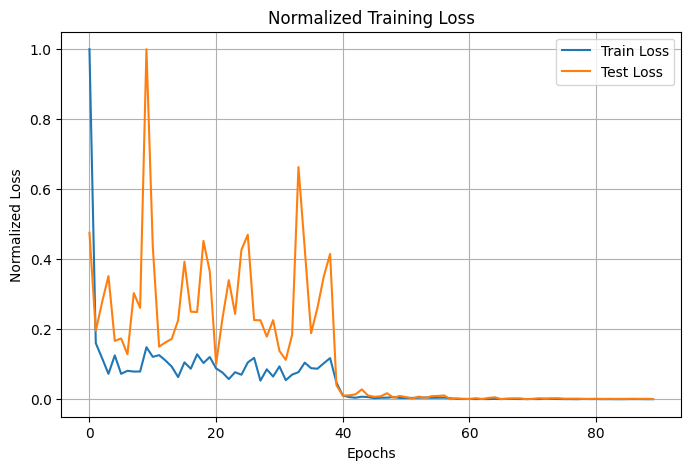

In [59]:
# Instantiate the model
model_0 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=20, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_0, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

Χρησιμοποιήσαμε τον optimizer ``` Adam ``` τώρα θα χρησιμοποιήσουμε τον ``` RMSProp```

Epoch 0 | Loss train: 870.893718 | Loss test: 120.836618 | lr = 0.01
Epoch 10 | Loss train: 36.024598 | Loss test: 25.964467 | lr = 0.01
Epoch 20 | Loss train: 34.621285 | Loss test: 17.593838 | lr = 0.01
Epoch 30 | Loss train: 31.782490 | Loss test: 33.480114 | lr = 0.01
Epoch 40 | Loss train: 0.699838 | Loss test: 0.985897 | lr = 0.001
Epoch 50 | Loss train: 0.655737 | Loss test: 0.920800 | lr = 0.001
Epoch 60 | Loss train: 0.639507 | Loss test: 0.714966 | lr = 0.001
Epoch 70 | Loss train: 0.310070 | Loss test: 0.495248 | lr = 0.0001
Epoch 80 | Loss train: 0.296621 | Loss test: 0.484129 | lr = 1e-05
Epoch 90 | Loss train: 0.284743 | Loss test: 0.489827 | lr = 1e-05
Early stopping at epoch 98
Loaded best model from temp_model.pth


C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\912520536.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


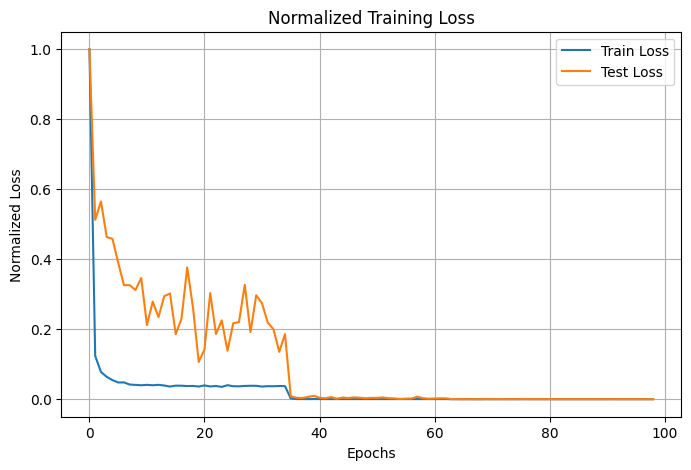

In [61]:
# Instantiate the model
model_1 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_1.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=30, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_1, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

Και τέλος χρησιμοποιούμε και τον ``` SGD ```

Epoch 0 | Loss train: 0.693939 | Loss test: 0.535768 | lr = 0.01
Epoch 10 | Loss train: 0.507533 | Loss test: 0.551840 | lr = 0.01
Epoch 20 | Loss train: 0.515561 | Loss test: 0.583350 | lr = 0.01
Epoch 30 | Loss train: 0.307924 | Loss test: 0.509181 | lr = 0.001
Epoch 40 | Loss train: 0.314718 | Loss test: 0.470256 | lr = 0.001
Epoch 50 | Loss train: 0.302023 | Loss test: 0.465477 | lr = 0.001
Epoch 60 | Loss train: 0.290512 | Loss test: 0.470815 | lr = 0.0001
Epoch 70 | Loss train: 0.289105 | Loss test: 0.468859 | lr = 0.0001
Epoch 80 | Loss train: 0.293872 | Loss test: 0.469240 | lr = 0.0001
Early stopping at epoch 83
Loaded best model from temp_model.pth


C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\912520536.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


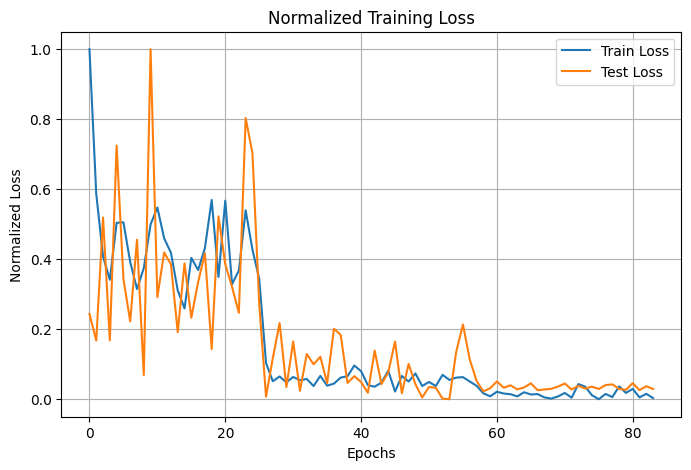

In [63]:
# Instantiate the model
model_2 = SimpleModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=learning_rate, momentum= 0.9)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=30, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_2, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

Έχοντας προπονήσει τα μοντέλα για 100 εποχές με διαφορετικούς optimizers παρατηρούμε ότι η καλύτερη απόδοση έιναι από τον ``` Adam ``` ο οποίος θα χρησιμοποιηθεί και μετέπειτα.

***

### Αρχιτεκτονική 2

#### ReLU 128

Το δεύτερο μοντέλο μας θα αποκτήσει άλλα 2 layers δίνοντας μας την δυνατότητα θεωρητικά να πετύχουμε μικρότερη απώλεια συγκριτικά με την απλούστερη περίπτωση. Επιπλέον μας δίνεται η δυνατότητα να μεταβάλλουμε τόσο την μεταβλητή ```hidden_units``` που καθορίζει το μέγεθος των ενδιάμεσων επιπέδων, όσο και τις συναρτήσεις ενεργοποίησης.

Για αρχή επιλέγουμε την συνηθέστερη επιλογή την συνάρτηση ``` ReLU```, ο τύπος της οποίας δίνεται παρακάτω.

$ReLU(x) = max(0,x)$

In [16]:
# Build the model

class ReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(ReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.ReLU(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 14.280306 | Loss test: 1.035248 | lr = 0.01
Epoch 10 | Loss train: 0.516224 | Loss test: 0.535361 | lr = 0.01
Epoch 20 | Loss train: 0.428956 | Loss test: 0.491915 | lr = 0.01
Epoch 30 | Loss train: 0.364018 | Loss test: 0.460864 | lr = 0.01
Epoch 40 | Loss train: 0.309277 | Loss test: 0.484508 | lr = 0.01
Epoch 50 | Loss train: 0.260536 | Loss test: 0.381932 | lr = 0.01
Epoch 60 | Loss train: 0.260735 | Loss test: 0.381634 | lr = 0.01
Epoch 70 | Loss train: 0.242382 | Loss test: 0.412245 | lr = 0.01
Epoch 80 | Loss train: 0.241764 | Loss test: 0.453571 | lr = 0.001
Epoch 90 | Loss train: 0.137663 | Loss test: 0.387484 | lr = 0.001
Epoch 100 | Loss train: 0.122234 | Loss test: 0.392017 | lr = 0.001
Epoch 110 | Loss train: 0.113012 | Loss test: 0.401101 | lr = 0.001
Epoch 120 | Loss train: 0.104372 | Loss test: 0.443290 | lr = 0.001
Epoch 130 | Loss train: 0.110126 | Loss test: 0.430320 | lr = 0.001
Epoch 140 | Loss train: 0.091810 | Loss test: 0.430964 | lr = 0.00

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


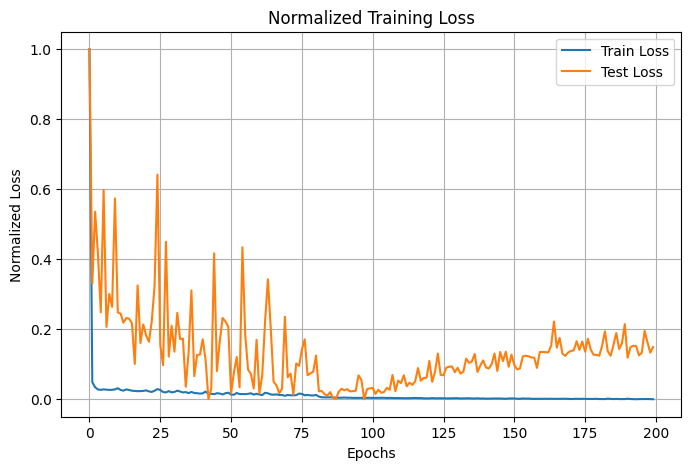

In [75]:
# Instantiate the model
model_3 = ReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=200, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_3, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

relu_model = eval_model(model_3, test_loader, scaler_rev, device)

In [76]:
relu_model

{'model_name': 'ReLUModel',
 'mean_distance_error_cm': 21.801074981689453,
 'std': 20.500715255737305}

Ήδη τα αποτελέσματα είναι πολύ καλύτερα συγκριτικά με την προηγούμενη αρχιτεκτονική. **NOT**

#### ReLU 256

Τώρα θα αυξήσουμε τον αριθμό των ```hidden_units```  από 128 σε 256 για να δούμε κάποια πιθανή διαφορά.

Epoch 0 | Loss train: 76.567656 | Loss test: 0.756883 | lr = 0.01
Epoch 10 | Loss train: 0.490136 | Loss test: 0.585832 | lr = 0.01
Epoch 20 | Loss train: 0.441800 | Loss test: 0.586191 | lr = 0.01
Epoch 30 | Loss train: 0.543534 | Loss test: 0.585305 | lr = 0.01
Epoch 40 | Loss train: 0.373268 | Loss test: 0.556692 | lr = 0.01
Epoch 50 | Loss train: 0.375096 | Loss test: 0.412988 | lr = 0.01
Epoch 60 | Loss train: 0.336684 | Loss test: 0.498940 | lr = 0.01
Epoch 70 | Loss train: 0.311424 | Loss test: 0.406648 | lr = 0.001
Epoch 80 | Loss train: 0.159118 | Loss test: 0.374661 | lr = 0.001
Epoch 90 | Loss train: 0.148427 | Loss test: 0.390340 | lr = 0.001
Epoch 100 | Loss train: 0.133247 | Loss test: 0.408492 | lr = 0.001
Epoch 110 | Loss train: 0.115725 | Loss test: 0.400924 | lr = 0.001
Epoch 120 | Loss train: 0.103263 | Loss test: 0.451994 | lr = 0.001
Epoch 130 | Loss train: 0.124797 | Loss test: 0.461663 | lr = 0.001
Epoch 140 | Loss train: 0.093420 | Loss test: 0.424663 | lr = 0.0

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


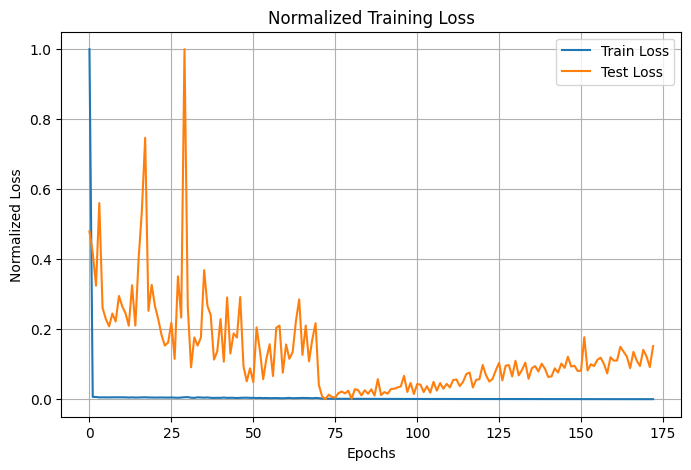

In [77]:
# Instantiate the model
model_4 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 256)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_4.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_4, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

relu_model_256 = eval_model(model_4, test_loader, scaler_rev, device)

In [78]:
relu_model_256, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 22.043272018432617,
  'std': 20.50890350341797},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 21.801074981689453,
  'std': 20.500715255737305})

#### ReLU 64

Τα αποτελέσματα με 128 hidden units είναι καλύτερα, δοκιμάζουμε τέλος με 64. **NOT**

Epoch 0 | Loss train: 2.695277 | Loss test: 1.165200 | lr = 0.01
Epoch 10 | Loss train: 0.323391 | Loss test: 0.499495 | lr = 0.01
Epoch 20 | Loss train: 0.263613 | Loss test: 0.417385 | lr = 0.01
Epoch 30 | Loss train: 0.213273 | Loss test: 0.416516 | lr = 0.01
Epoch 40 | Loss train: 0.237643 | Loss test: 0.414147 | lr = 0.01
Epoch 50 | Loss train: 0.208287 | Loss test: 0.393073 | lr = 0.01
Epoch 60 | Loss train: 0.105436 | Loss test: 0.324293 | lr = 0.001
Epoch 70 | Loss train: 0.088146 | Loss test: 0.331037 | lr = 0.001
Epoch 80 | Loss train: 0.082520 | Loss test: 0.353880 | lr = 0.001
Epoch 90 | Loss train: 0.077301 | Loss test: 0.364247 | lr = 0.001
Epoch 100 | Loss train: 0.070354 | Loss test: 0.355141 | lr = 0.001
Epoch 110 | Loss train: 0.064266 | Loss test: 0.354930 | lr = 0.001
Epoch 120 | Loss train: 0.060507 | Loss test: 0.355917 | lr = 0.001
Epoch 130 | Loss train: 0.059622 | Loss test: 0.354219 | lr = 0.001
Epoch 140 | Loss train: 0.054097 | Loss test: 0.365469 | lr = 0.0

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


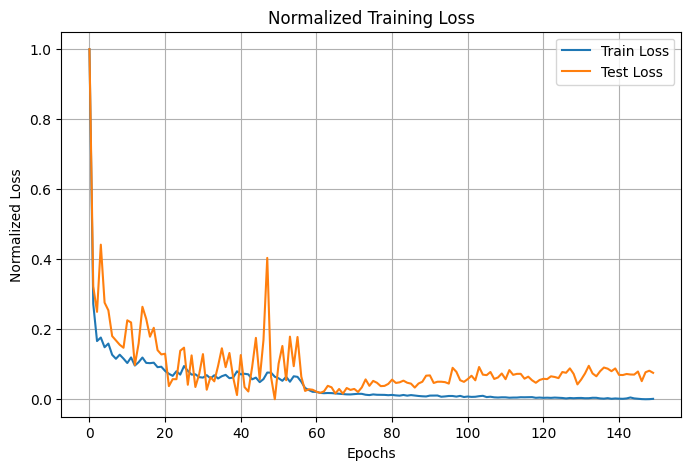

In [79]:
# Instantiate the model
model_5 = ReLUModel(input_size=input_len, output_size=output_len, hidden_units= 64)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_5.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_5, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

relu_model_64 = eval_model(model_5, test_loader, scaler_rev, device)

In [80]:
relu_model_256, relu_model_64, relu_model

({'model_name': 'ReLUModel',
  'mean_distance_error_cm': 22.043272018432617,
  'std': 20.50890350341797},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 19.633459091186523,
  'std': 18.309350967407227},
 {'model_name': 'ReLUModel',
  'mean_distance_error_cm': 21.801074981689453,
  'std': 20.500715255737305})

Η καλύτερη περίπτωση φαίνεται να είναι με 64 ```hidden_units```

***

### Αρχιτεκτονική 2.1

#### LeakyRELU

Για την συγκεκριμένη αρχιτεκτονική και τα συγκεκριμένα ```hidden_units``` θα μελετήσουμε την διαφορά που προκαλούν διάφορες συναρτήσεις ενεργοποίησης.

Αρχικά μελετάμε την LeakyReLU, με τύπο:

$LeakyReLU(x) = max(0,x) + negative\_slope * min(0,x)$

In [110]:
class LeakyReLUModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 128):
        super(LeakyReLUModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 9.162900 | Loss test: 3.492709 | lr = 0.01
Epoch 10 | Loss train: 0.467378 | Loss test: 0.936620 | lr = 0.01
Epoch 20 | Loss train: 0.375629 | Loss test: 0.455427 | lr = 0.01
Epoch 30 | Loss train: 0.162209 | Loss test: 0.398476 | lr = 0.001
Epoch 40 | Loss train: 0.122150 | Loss test: 0.290251 | lr = 0.001
Epoch 50 | Loss train: 0.106732 | Loss test: 0.292153 | lr = 0.001
Epoch 60 | Loss train: 0.079666 | Loss test: 0.306867 | lr = 0.001
Epoch 70 | Loss train: 0.065960 | Loss test: 0.313419 | lr = 0.001
Epoch 80 | Loss train: 0.051857 | Loss test: 0.316979 | lr = 0.001
Epoch 90 | Loss train: 0.046339 | Loss test: 0.312359 | lr = 0.001
Epoch 100 | Loss train: 0.048004 | Loss test: 0.289752 | lr = 0.001
Epoch 110 | Loss train: 0.043736 | Loss test: 0.319627 | lr = 0.001
Epoch 120 | Loss train: 0.033823 | Loss test: 0.314974 | lr = 0.001
Epoch 130 | Loss train: 0.036408 | Loss test: 0.338436 | lr = 0.001
Epoch 140 | Loss train: 0.032924 | Loss test: 0.340655 | lr = 

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


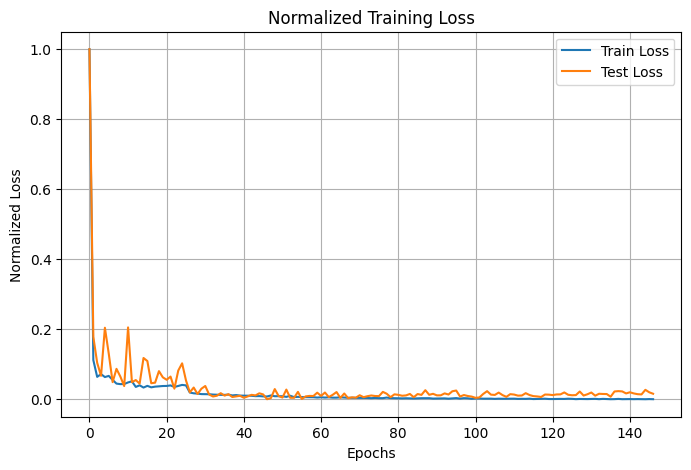

In [111]:
# Instantiate the model
model_6 = LeakyReLUModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_6.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)


# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_6, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

leakyrelu = eval_model(model_6, test_loader, scaler_rev, device)

In [112]:
leakyrelu

{'model_name': 'LeakyReLUModel',
 'mean_distance_error_cm': 17.61983299255371,
 'std': 18.864717483520508}

#### Tanh

Δοκιμάζουμε την συνάρτηση ενεργοποίησης tanh. 

$tanh(x) = \frac{exp(x) - exp(-x)}{exp(x) + exp(-x)}$

In [85]:
class tanhModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(tanhModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Tanh(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.670522 | Loss test: 0.699010 | lr = 0.01
Epoch 10 | Loss train: 0.421826 | Loss test: 0.576542 | lr = 0.01
Epoch 20 | Loss train: 0.403791 | Loss test: 0.601134 | lr = 0.01
Epoch 30 | Loss train: 0.375921 | Loss test: 0.640789 | lr = 0.01
Epoch 40 | Loss train: 0.388756 | Loss test: 0.538791 | lr = 0.001
Epoch 50 | Loss train: 0.248605 | Loss test: 0.488768 | lr = 0.001
Epoch 60 | Loss train: 0.231589 | Loss test: 0.496752 | lr = 0.001
Epoch 70 | Loss train: 0.204803 | Loss test: 0.511472 | lr = 0.001
Epoch 80 | Loss train: 0.197913 | Loss test: 0.515393 | lr = 0.001
Epoch 90 | Loss train: 0.188444 | Loss test: 0.511813 | lr = 0.001
Epoch 100 | Loss train: 0.174861 | Loss test: 0.523108 | lr = 0.001
Epoch 110 | Loss train: 0.170261 | Loss test: 0.522316 | lr = 0.001
Epoch 120 | Loss train: 0.154851 | Loss test: 0.548139 | lr = 0.001
Epoch 130 | Loss train: 0.148602 | Loss test: 0.545929 | lr = 0.001
Epoch 140 | Loss train: 0.147136 | Loss test: 0.548864 | lr = 0

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


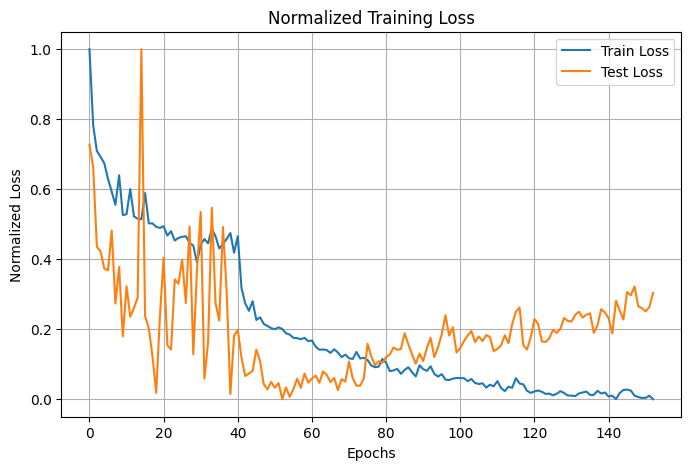

In [86]:
# Instantiate the model
model_8 = tanhModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_8.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_8, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

tanh_model = eval_model(model_8, test_loader, scaler_rev, device)

#### Sigmoid

$Sigmoid(x) = \frac{1}{1+exp(-x)}$

In [28]:
class sigmoidModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(sigmoidModel, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.Sigmoid(),
            nn.Linear(in_features= hidden_units, out_features= output_size),   
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 0.666908 | Loss test: 0.632329 | lr = 0.01
Epoch 10 | Loss train: 0.412976 | Loss test: 0.535843 | lr = 0.01
Epoch 20 | Loss train: 0.340698 | Loss test: 0.492450 | lr = 0.01
Epoch 30 | Loss train: 0.342848 | Loss test: 0.557045 | lr = 0.01
Epoch 40 | Loss train: 0.302940 | Loss test: 0.438109 | lr = 0.01
Epoch 50 | Loss train: 0.295239 | Loss test: 0.534223 | lr = 0.01
Epoch 60 | Loss train: 0.266370 | Loss test: 0.477419 | lr = 0.01
Epoch 70 | Loss train: 0.254051 | Loss test: 0.442761 | lr = 0.001
Epoch 80 | Loss train: 0.212431 | Loss test: 0.419853 | lr = 0.001
Epoch 90 | Loss train: 0.197569 | Loss test: 0.428700 | lr = 0.001
Epoch 100 | Loss train: 0.192119 | Loss test: 0.433286 | lr = 0.001
Epoch 110 | Loss train: 0.195659 | Loss test: 0.432736 | lr = 0.001
Epoch 120 | Loss train: 0.174637 | Loss test: 0.437018 | lr = 0.001
Epoch 130 | Loss train: 0.168372 | Loss test: 0.440333 | lr = 0.001
Epoch 140 | Loss train: 0.170952 | Loss test: 0.447702 | lr = 0.00

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


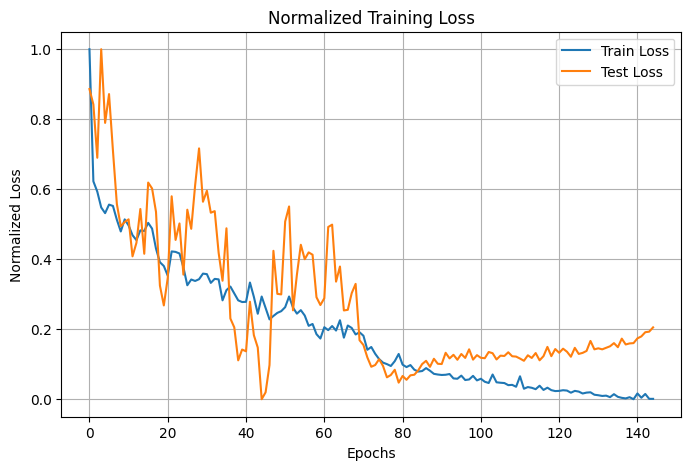

In [87]:
# Instantiate the model
model_9 = sigmoidModel(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_9.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_9, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

sigmoid_model = eval_model(model_9, test_loader, scaler_rev, device)

### Αρχιτεκτονική 3

#### +1 Layer

Μιας και βλέπουμε ότι τα καλύτερα αποτελέσματα τα δίνει το μοντέλο με συνάρτηση ενεργοποίησης LeakyReLU , θα δοκιμάσουμε να βάλουμε άλλο ένα layer για να δούμε πως θα επηρεαστουν τα αποτελέσματα.

In [30]:
class LeakyReLUModel4(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel4, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 1.336031 | Loss test: 0.596329 | lr = 0.01
Epoch 10 | Loss train: 0.334425 | Loss test: 0.415120 | lr = 0.01
Epoch 20 | Loss train: 0.248818 | Loss test: 0.391184 | lr = 0.01
Epoch 30 | Loss train: 0.195649 | Loss test: 0.368852 | lr = 0.01
Epoch 40 | Loss train: 0.189595 | Loss test: 0.334452 | lr = 0.01
Epoch 50 | Loss train: 0.129309 | Loss test: 0.288827 | lr = 0.001
Epoch 60 | Loss train: 0.085111 | Loss test: 0.303615 | lr = 0.001
Epoch 70 | Loss train: 0.077271 | Loss test: 0.312421 | lr = 0.001
Epoch 80 | Loss train: 0.065107 | Loss test: 0.336379 | lr = 0.001
Epoch 90 | Loss train: 0.061695 | Loss test: 0.321063 | lr = 0.001
Epoch 100 | Loss train: 0.054021 | Loss test: 0.312486 | lr = 0.001
Epoch 110 | Loss train: 0.041573 | Loss test: 0.333148 | lr = 0.001
Epoch 120 | Loss train: 0.040879 | Loss test: 0.338361 | lr = 0.001
Epoch 130 | Loss train: 0.038553 | Loss test: 0.332925 | lr = 0.001
Epoch 140 | Loss train: 0.034784 | Loss test: 0.327107 | lr = 0.

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


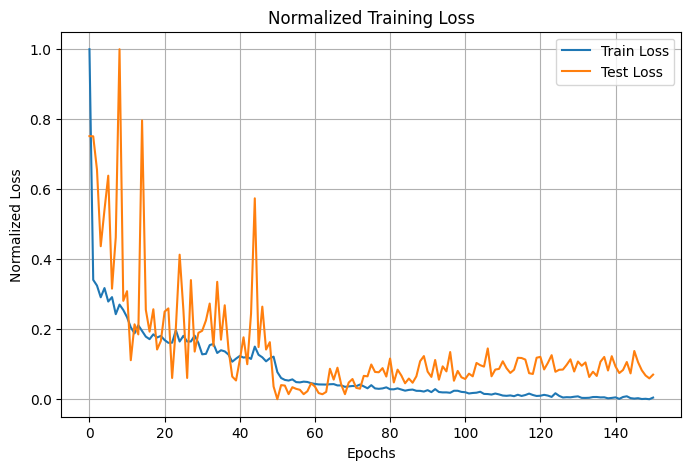

In [88]:
# Instantiate the model
model_10 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_10.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_10, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

leakyrelu_4 = eval_model(model_10, test_loader, scaler_rev, device)

Παρατηρούμε ότι η επίδοση του μοντέλου δεν καλυτέρεψε, άρα δεν χρειάζεται να προσθέσουμε και άλλα layers.

#### -1 Layer

In [32]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 86.783576 | Loss test: 10.617001 | lr = 0.01
Epoch 10 | Loss train: 0.453748 | Loss test: 0.483045 | lr = 0.01
Epoch 20 | Loss train: 0.374556 | Loss test: 0.571160 | lr = 0.01
Epoch 30 | Loss train: 0.415175 | Loss test: 0.425558 | lr = 0.01
Epoch 40 | Loss train: 0.414511 | Loss test: 0.696358 | lr = 0.01
Epoch 50 | Loss train: 0.531655 | Loss test: 0.563726 | lr = 0.01
Epoch 60 | Loss train: 0.353040 | Loss test: 0.415490 | lr = 0.01
Epoch 70 | Loss train: 0.399266 | Loss test: 0.503508 | lr = 0.01
Epoch 80 | Loss train: 0.337038 | Loss test: 0.532816 | lr = 0.01
Epoch 90 | Loss train: 0.149952 | Loss test: 0.388298 | lr = 0.001
Epoch 100 | Loss train: 0.144099 | Loss test: 0.410056 | lr = 0.001
Epoch 110 | Loss train: 0.124481 | Loss test: 0.370989 | lr = 0.001
Epoch 120 | Loss train: 0.107318 | Loss test: 0.409185 | lr = 0.001
Epoch 130 | Loss train: 0.106278 | Loss test: 0.393691 | lr = 0.001
Epoch 140 | Loss train: 0.124450 | Loss test: 0.398409 | lr = 0.00

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


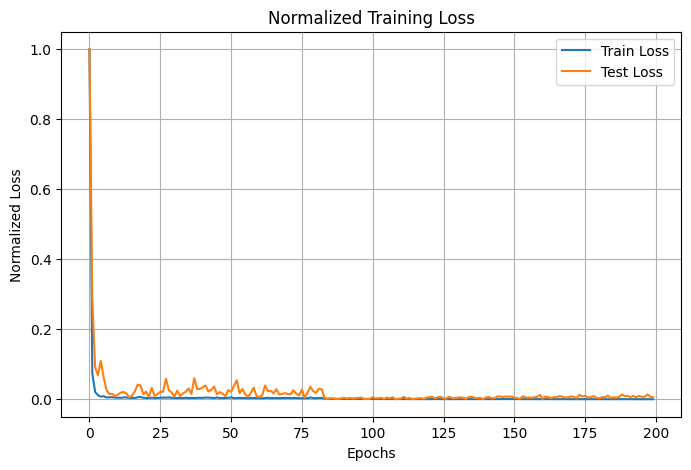

In [89]:
# Instantiate the model
model_14 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_14.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=20)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_14, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

leakyrelu_2 = eval_model(model_14, test_loader, scaler_rev, device)

#### -1 Layer rmsprop

In [34]:
class LeakyReLUModel2(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 64):
        super(LeakyReLUModel2, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Linear(in_features= hidden_units, out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 5495.179743 | Loss test: 390.404367 | lr = 0.01
Epoch 10 | Loss train: 3.817006 | Loss test: 3.376533 | lr = 0.01
Epoch 20 | Loss train: 3.375322 | Loss test: 5.901046 | lr = 0.01
Epoch 30 | Loss train: 1.113000 | Loss test: 0.466083 | lr = 0.001
Epoch 40 | Loss train: 0.220628 | Loss test: 0.377056 | lr = 0.001
Epoch 50 | Loss train: 0.189359 | Loss test: 0.404010 | lr = 0.001
Epoch 60 | Loss train: 0.181937 | Loss test: 0.337502 | lr = 0.001
Epoch 70 | Loss train: 0.167581 | Loss test: 0.580256 | lr = 0.001
Epoch 80 | Loss train: 0.172656 | Loss test: 0.336745 | lr = 0.001
Epoch 90 | Loss train: 0.146194 | Loss test: 0.379720 | lr = 0.001
Epoch 100 | Loss train: 0.139434 | Loss test: 0.414890 | lr = 0.001
Epoch 110 | Loss train: 0.141960 | Loss test: 0.407323 | lr = 0.001
Epoch 120 | Loss train: 0.134725 | Loss test: 0.432176 | lr = 0.001
Epoch 130 | Loss train: 0.135022 | Loss test: 0.360018 | lr = 0.001
Epoch 140 | Loss train: 0.135059 | Loss test: 0.465515 | 

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


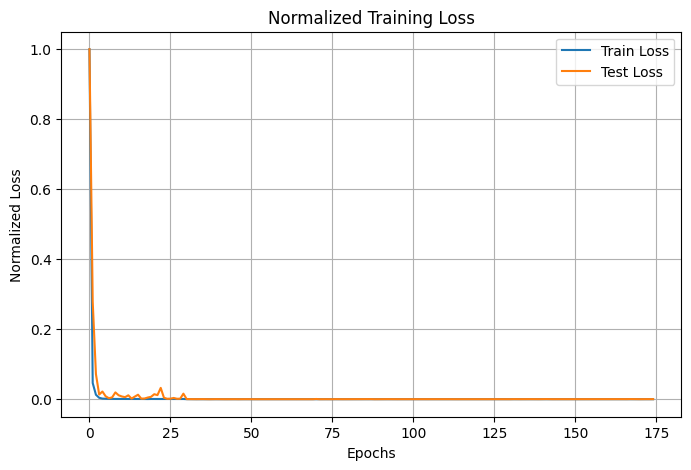

In [90]:
# Instantiate the model
model_15 = LeakyReLUModel2(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.RMSprop(model_15.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_15, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

leakyrelu_2_rms = eval_model(model_15, test_loader, scaler_rev, device)

### Αρχιτεκτονική 4

#### Dropout

Θα προσθέσουμε ένα άλλο επίπεδο που συνίσταται σε μοντέλα με μικρά datasets, το ```Dropout```. Αυτό, με πιθανότητα p "νεκρώνει" έναν νευρώνα, βοηθώντας έτσι το μοντέλο να κατανοήσει γενικότερα συμπεράσματα για τα δεδομένα που του δίνουμε.

In [183]:
class LeakyReLUModelDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_units = 256):
        super(LeakyReLUModelDropout, self).__init__()

        self.linear_stack = nn.Sequential(
            nn.Linear(in_features= input_size, out_features= hidden_units),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.2),
            nn.Linear(in_features= hidden_units, out_features= int(hidden_units/2)),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.1),
            nn.Linear(in_features= int(hidden_units/2), out_features= output_size)
        )
    
    def forward(self, x):
        return self.linear_stack(x)

Epoch 0 | Loss train: 44.682500 | Loss test: 5.857745 | lr = 0.01
Epoch 10 | Loss train: 0.574323 | Loss test: 0.618124 | lr = 0.01
Epoch 20 | Loss train: 0.659641 | Loss test: 0.570280 | lr = 0.01
Epoch 30 | Loss train: 0.318611 | Loss test: 0.447877 | lr = 0.001
Epoch 40 | Loss train: 0.264967 | Loss test: 0.310677 | lr = 0.001
Epoch 50 | Loss train: 0.217330 | Loss test: 0.279709 | lr = 0.001
Epoch 60 | Loss train: 0.203035 | Loss test: 0.291706 | lr = 0.001
Epoch 70 | Loss train: 0.181421 | Loss test: 0.293051 | lr = 0.0001
Epoch 80 | Loss train: 0.142610 | Loss test: 0.275068 | lr = 0.0001
Epoch 90 | Loss train: 0.128130 | Loss test: 0.278809 | lr = 0.0001
Epoch 100 | Loss train: 0.121458 | Loss test: 0.272652 | lr = 0.0001
Epoch 110 | Loss train: 0.124351 | Loss test: 0.274300 | lr = 0.0001
Epoch 120 | Loss train: 0.115405 | Loss test: 0.269341 | lr = 0.0001
Epoch 130 | Loss train: 0.112068 | Loss test: 0.271579 | lr = 1e-05
Epoch 140 | Loss train: 0.106397 | Loss test: 0.269437 

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


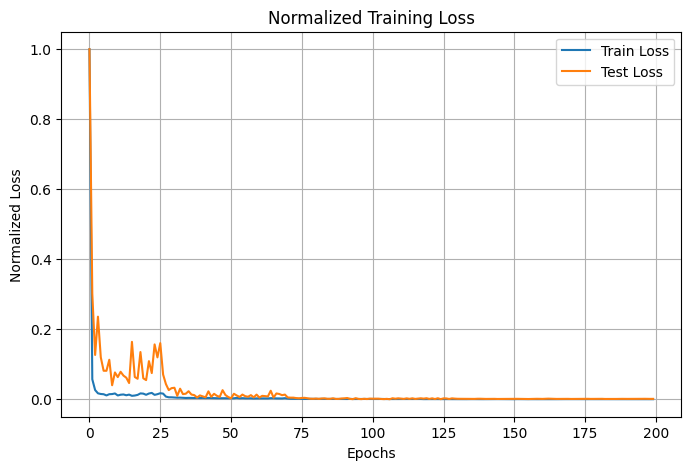

In [184]:
# Instantiate the model
model_11 = LeakyReLUModelDropout(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_11.parameters(), lr=learning_rate, weight_decay=1e-4)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_11, train_loader= train_loader, test_loader= test_loader, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

dropout_model = eval_model(model_11, test_loader, scaler_rev, device)

### Αρχιτεκτονική 5

#### XGB

Θα χρησιμοποιήσουμε και τον γνωστό αλγόριθμο για regression XGB, με την βοήθεια του MultiOutputRegressor.

In [38]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [39]:
xgb_model = xgb.XGBRegressor(random_state=42, n_estimators=1500, learning_rate=0.01, eta = 0.2, tree_method = 'hist', device = 'cuda')

# Fit the model
multi_xgb = MultiOutputRegressor(xgb_model)
multi_xgb.fit(X_train_scaled, y_train) 

# Predict the model
y_pred = multi_xgb.predict(X_test_scaled)

# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred)
y_true_real = scaler_Y.inverse_transform(y_test)

xgb_loss = np.mean(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_var = np.std(np.linalg.norm(y_pred_real - y_true_real, axis=1))
xgb_res = {'model_name': 'xgb_model', 'mean_distance_error_cm' : xgb_loss, 'std': xgb_var}

c:\Users\jimka\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:05:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


### Αρχιτεκτονική 6

#### Epochs

Θα δοκιμάσουμε επίσης αντί να δημιουργούμε batches να περνάμε τα data απευθείας στο μοντέλο.

Για την δοκιμή αυτή θα χρησιμοποιήσουμε το μοντέλο LeakyReLUModel4 με συνάρτηση ενεργοποίησης την LeakyReLU και 4 επίπεδα.

Δεν δημιουργώ συναρτήσεις αφού είναι μεμονομένη περίπτωση.

In [40]:
# Instantiate the model
model_13 = LeakyReLUModel4(input_size=input_len, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_13.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

In [41]:
X = info_tensor.reshape(len(info_tensor), -1)
y = rfid_label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
# Fit the scaler on the training data and transform both the training and test sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_Y = StandardScaler()
# Also scale the Y input since when we use MSE loss and the labels are in CM, MSE will scale quadratically with those values
y_train = scaler_Y.fit_transform(y_train)
y_test = scaler_Y.transform(y_test)


In [42]:
# Set seed before defining model and optimizer
torch.manual_seed(42)  

# Move model to device **before** training
model_13.to(device)

# Convert data to PyTorch tensors and move to device
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32, device=device)

# Set number of epochs
epochs = 1000  

# Training loop
for epoch in range(epochs):
    model_13.train()
    
    # Forward pass
    y_pred = model_13(X_train_tensor)

    # Compute loss
    loss = loss_fn(y_pred, y_train_tensor)  

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Evaluation
    model_13.eval()
    with torch.inference_mode():
        test_logits = model_13(X_test_tensor)
        test_loss = loss_fn(test_logits, y_test_tensor).detach()  # Ensure no gradients


    # Update learning rate scheduler
    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(test_loss.detach())  
    else:
        scheduler.step()

    # Print every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")
print(f"Epoch: {epoch + 1} | Train Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")


model_13.eval()
with torch.inference_mode():
    y_pred = model_13(X_test_tensor)
# Reverse scaling
y_pred_real = scaler_Y.inverse_transform(y_pred.cpu())
y_true_real = scaler_Y.inverse_transform(y_test_tensor.cpu())

distances = np.linalg.norm(y_pred_real - y_true_real, axis=1)
mean_distance_error = np.mean(distances)
std = np.std(distances)

epoch_res = {'model_name': 'LeakyReLU4_noBatches', 'mean_distance_error_cm' : mean_distance_error.item(), 'std': std.item()}

Epoch: 0 | Train Loss: 1.00714 | Test Loss: 2.33689
Epoch: 100 | Train Loss: 0.19401 | Test Loss: 0.37669
Epoch: 200 | Train Loss: 0.14146 | Test Loss: 0.35487
Epoch: 300 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 400 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 500 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 600 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 700 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 800 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 900 | Train Loss: 0.12855 | Test Loss: 0.35547
Epoch: 1000 | Train Loss: 0.12855 | Test Loss: 0.35547


***

### Αρχιτεκτονική 7

#### 1D CNN

In [164]:
class CNN1DModel(nn.Module):
    def __init__(self, input_channels=4, output_size=2):
        super(CNN1DModel, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=7, stride=1, padding=2),
            nn.BatchNorm1d(32),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(32, 64, 5, stride=1, padding=2),
            nn.BatchNorm1d(64),
            nn.LeakyReLU(0.1),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, 3, stride=1, padding=1),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.1),
            nn.AdaptiveAvgPool1d(1),  # Output shape: (batch_size, 128, 1)
        )
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(128, output_size)

    def forward(self, x):
        #x = x.permute(0, 2, 1)  # (batch, 500, 4) → (batch, 4, 500)
        x = self.conv_stack(x)  # (batch, 128, 1)
        x = x.view(x.size(0), -1)  # Flatten to (batch, 128)
        return self.fc(self.dropout(x))

In [142]:
def data_func_cnn(input_array, labels, batch_size=32, test_size=0.2):
    # No flattening; keep the input as (samples, 1000, 4)
    y = labels[:, :2]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(input_array, y, test_size=test_size, random_state=42)

    # Optionally normalize features **per channel** (across time and samples)
    # Reshape to (samples * time, features) for scaling
    samples_train, time_steps, features = X_train.shape
    X_train_reshaped = X_train.reshape(-1, features)
    X_test_reshaped = X_test.reshape(-1, features)

    scaler_X = StandardScaler()
    X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(samples_train, time_steps, features)
    X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape[0], time_steps, features)

    # Scale Y (labels)
    scaler_Y = StandardScaler()
    y_train_scaled = scaler_Y.fit_transform(y_train)
    y_test_scaled = scaler_Y.transform(y_test)

    # Convert to tensors and move channel dim for CNN input (B, C, L)
    # Current: (B, 1000, 4) → CNN wants (B, 4, 1000)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).permute(0, 2, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).permute(0, 2, 1)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

    # Create datasets
    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    test_data = TensorDataset(X_test_tensor, y_test_tensor)

    # Data loaders
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_data, batch_size=batch_size)

    return train_loader, test_loader, scaler_Y

In [143]:
train_loader_cnn, test_loader_cnn, scaler_rev_cnn = data_func_cnn(info_tensor, rfid_label)

Epoch 0 | Loss train: 0.594841 | Loss test: 0.854770 | lr = 0.01
Epoch 10 | Loss train: 0.404027 | Loss test: 0.422222 | lr = 0.01
Epoch 20 | Loss train: 0.421217 | Loss test: 0.443101 | lr = 0.01
Epoch 30 | Loss train: 0.370263 | Loss test: 0.395291 | lr = 0.01
Epoch 40 | Loss train: 0.359927 | Loss test: 0.410045 | lr = 0.01
Epoch 50 | Loss train: 0.346963 | Loss test: 0.388632 | lr = 0.01
Epoch 60 | Loss train: 0.353421 | Loss test: 0.375745 | lr = 0.01
Epoch 70 | Loss train: 0.337711 | Loss test: 0.389189 | lr = 0.01
Epoch 80 | Loss train: 0.313688 | Loss test: 0.374262 | lr = 0.001
Epoch 90 | Loss train: 0.298632 | Loss test: 0.365214 | lr = 0.001
Epoch 100 | Loss train: 0.299959 | Loss test: 0.368644 | lr = 0.0001
Epoch 110 | Loss train: 0.289874 | Loss test: 0.366061 | lr = 1e-05
Epoch 120 | Loss train: 0.279620 | Loss test: 0.368820 | lr = 1e-05
Epoch 130 | Loss train: 0.306038 | Loss test: 0.363745 | lr = 1e-05
Epoch 140 | Loss train: 0.293885 | Loss test: 0.361422 | lr = 1e-0

C:\Users\jimka\AppData\Local\Temp\ipykernel_16712\1930630724.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(early_stopper.path))


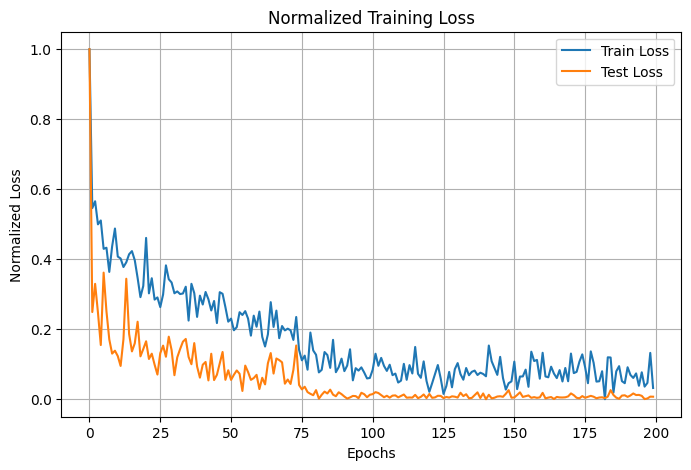

In [165]:
# Instantiate the model
model_16 = CNN1DModel(input_channels=4, output_size=output_len)

# Define loss fucntion and optimizer
learning_rate = 1e-2


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_16.parameters(), lr=learning_rate)

# Initialize the scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, min_lr= 1e-5)
# Initialize early stopping
early_stopper = EarlyStopping(patience=100, min_delta=1e-5, verbose=False, path='temp_model.pth')

# Load the data
arr1, arr2 = train_test_model(epoch = 200,model = model_16, train_loader= train_loader_cnn, test_loader= test_loader_cnn, loss_fn= loss_fn, optimizer=optimizer, scheduler= scheduler,early_stopper= early_stopper, device=device)

plot_results(arr1, arr2)

cnn_model = eval_model(model_16, test_loader_cnn, scaler_rev_cnn, device)

In [163]:
cnn_model

{'model_name': 'CNN1DModel',
 'mean_distance_error_cm': 20.293132781982422,
 'std': 18.49445343017578}

## Results

In [185]:
compare_results = pd.DataFrame([leakyrelu, leakyrelu_4, leakyrelu_2,leakyrelu_2_rms, relu_model,dropout_model, sigmoid_model, tanh_model, cnn_model])
compare_results = compare_results._append(xgb_res, ignore_index = True)
compare_results = compare_results._append(epoch_res, ignore_index = True)
compare_results.sort_values(by = 'mean_distance_error_cm', ascending= True, inplace= True)

compare_results

,model_name,mean_distance_error_cm,std
5,LeakyReLUModelDropout,16.002935,18.658045
0,LeakyReLUModel,17.619833,18.864717
1,LeakyReLUModel4,17.758980,18.333567
9,xgb_model,18.068656,16.809581
10,LeakyReLU4_noBatches,19.433358,20.748325
2,LeakyReLUModel2,19.585833,22.155064
3,LeakyReLUModel2,20.175795,21.165159
8,CNN1DModel,21.470240,19.332897
4,ReLUModel,21.801075,20.500715
6,sigmoidModel,24.759285,23.514631


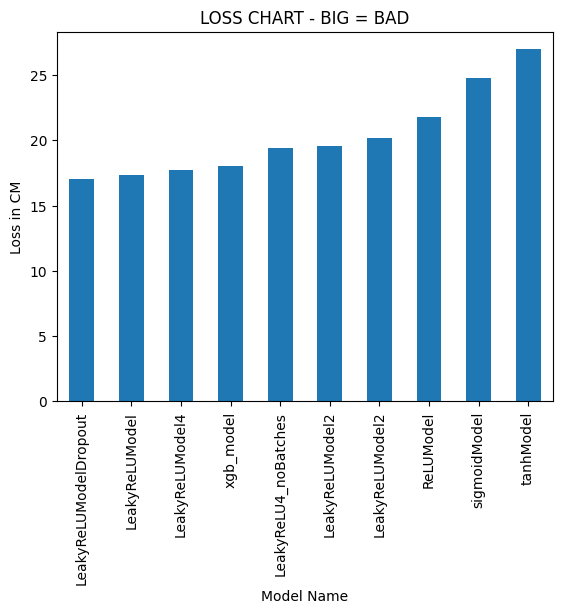

In [94]:
# Visualize our model results
compare_results.set_index("model_name")["mean_distance_error_cm"].plot(kind="bar")
plt.xlabel("Model Name")
plt.ylabel("Loss in CM")
plt.title("LOSS CHART - BIG = BAD")
plt.show()

***